## Setup ##

In [2]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket()
print(bucket)

prefix = 'fraud/supervised' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::166738912916:role/service-role/AmazonSageMaker-ExecutionRole-20190123T085186
sagemaker-us-east-2-166738912916


## Get the data ##

In [2]:
!wget https://s3.amazonaws.com/ja-misc-stuff/paysim1.zip

--2019-01-23 15:17:06--  https://s3.amazonaws.com/ja-misc-stuff/paysim1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.108.173
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.108.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190835595 (182M) [application/zip]
Saving to: ‘paysim1.zip’

paysim1.zip         100%[===================>] 181.99M  58.6MB/s    in 3.1s    

2019-01-23 15:17:09 (58.6 MB/s) - ‘paysim1.zip’ saved [190835595/190835595]



## Unzip the payload ##

In [3]:
!unzip paysim1.zip

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


## Get the head of the data to verify ##

In [4]:
!head PS_20174392719_1491204439457_log.csv

step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,0
1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,0
1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0
1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.0,0,0
1,PAYMENT,4024.36,C1265012928,2671.0,0.0,M1176932104,0.0,0.0,0,0


## Load the data ##

In [15]:
import pandas as pd
transaction_data = pd.read_csv('PS_20174392719_1491204439457_log.csv', delimiter=',',nrows=10000)

## Clean out the data we don't need ##

In [88]:
cleaned_set = transaction_data.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
indexNames = cleaned_set[ cleaned_set['type'] == 'PAYMENT' ].index
 
# Delete these row indexes from dataFrame
cleaned_set.drop(indexNames , inplace=True)

## Validate data ##

### Headers ###

In [89]:
print(list(cleaned_set))

['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']


### Data ###

In [90]:
cleaned_set.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.00,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.00,1
9,1,DEBIT,5337.77,41720.0,36382.23,41898.0,40348.79,0
10,1,DEBIT,9644.94,4465.0,0.00,10845.0,157982.12,0
15,1,CASH_OUT,229133.94,15325.0,0.00,5083.0,51513.44,0


## Compare the items that are fraud with items that were marked by rules engine as fraud ##

In [91]:
real_fraud = transaction_data[ transaction_data['isFraud'] == 1]
rules_fraud = transaction_data[ transaction_data['isFlaggedFraud'] == 1]

In [92]:
print(real_fraud.shape[0])
print(rules_fraud.shape[0])

68
0


## Plot histogram to compare non-fraud to fraud ##

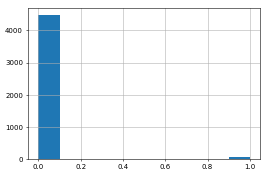

In [93]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi'] = 50

cleaned_set.isFraud.hist()

## Convert type to number via one hot encoding ##

In [94]:
encoded_data = pd.get_dummies(cleaned_set['type'])
encoded_data.head()

,CASH_IN,CASH_OUT,DEBIT,TRANSFER
2,0,0,0,1
3,0,1,0,0
9,0,0,1,0
10,0,0,1,0
15,0,1,0,0


In [95]:
temp_data = pd.concat([cleaned_set,encoded_data],axis=1)
final_data = temp_data.drop(['type'],axis=1)
final_data.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,TRANSFER
2,1,181.00,181.0,0.00,0.0,0.00,1,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.00,1,0,1,0,0
9,1,5337.77,41720.0,36382.23,41898.0,40348.79,0,0,0,1,0
10,1,9644.94,4465.0,0.00,10845.0,157982.12,0,0,0,1,0
15,1,229133.94,15325.0,0.00,5083.0,51513.44,0,0,1,0,0


## Training ##

In [ ]:
from sagemaker import RandomCutForest

session = sagemaker.Session()

# specify general training job information
rcf = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/'.format(bucket, prefix),
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=512,
                      num_trees=50)

# automatically upload the training data to S3 and run the training job
rcf.fit(rcf.record_set(final_data.as_matrix().reshape(-1,1)))

INFO:sagemaker:Creating training-job with name: randomcutforest-2019-01-23-19-38-47-154


2019-01-23 19:38:47 Starting - Starting the training job...
2019-01-23 19:38:49 Starting - Launching requested ML instances...
2019-01-23 19:39:45 Starting - Preparing the instances for training........

In [59]:
print('Training job name: {}'.format(rcf.latest_training_job.job_name))

Training job name: randomcutforest-2019-01-23-19-05-38-822


In [62]:
#sagemaker.Session().delete_endpoint(rcf_inference.endpoint)

INFO:sagemaker:Deleting endpoint with name: randomcutforest-2019-01-23-16-54-45-618


In [64]:
rcf_inference = rcf.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
)

INFO:sagemaker:Creating model with name: randomcutforest-2019-01-23-19-13-43-537
INFO:sagemaker:Creating endpoint with name randomcutforest-2019-01-23-19-05-38-822


--------------------------------------------------------------------------!

In [65]:
print('Endpoint name: {}'.format(rcf_inference.endpoint))

Endpoint name: randomcutforest-2019-01-23-19-05-38-822


In [66]:
from sagemaker.predictor import csv_serializer, json_deserializer

rcf_inference.content_type = 'text/csv'
rcf_inference.serializer = csv_serializer
rcf_inference.accept = 'application/json'
rcf_inference.deserializer = json_deserializer

In [85]:
fraud_data_numpy = final_data.isFraud.as_matrix().reshape(-1,1)
print(fraud_data_numpy[:6])
results = rcf_inference.predict(fraud_data_numpy[:6])

[[1]
 [1]
 [0]
 [0]
 [0]
 [0]]


## Computing Anomaly Scores

Now, let's compute and plot the anomaly scores from the entire transaction dataset.

In [87]:
results = rcf_inference.predict(fraud_data_numpy)
scores = [datum['score'] for datum in results['scores']]

# add scores to transaction data frame and print first few values
final_data['score'] = pd.Series(scores, index=final_data.index)
final_data.head(50)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,CASH_IN,CASH_OUT,DEBIT,TRANSFER,score
2,1,181.00,181.00,0.00,0.00,0.00,1,0,0,0,0,1,0.482602
3,1,181.00,181.00,0.00,21182.00,0.00,1,0,0,1,0,0,0.482602
9,1,5337.77,41720.00,36382.23,41898.00,40348.79,0,0,0,0,1,0,0.445481
10,1,9644.94,4465.00,0.00,10845.00,157982.12,0,0,0,0,1,0,0.445481
15,1,229133.94,15325.00,0.00,5083.00,51513.44,0,0,0,1,0,0,0.445481
19,1,215310.30,705.00,0.00,22425.00,0.00,0,0,0,0,0,1,0.445481
21,1,9302.79,11299.00,1996.21,29832.00,16896.70,0,0,0,0,1,0,0.445481
22,1,1065.41,1817.00,751.59,10330.00,0.00,0,0,0,0,1,0,0.445481
24,1,311685.89,10835.00,0.00,6267.00,2719172.89,0,0,0,0,0,1,0.445481
41,1,5758.59,32604.00,26845.41,209699.00,16997.22,0,0,0,0,1,0,0.445481
